In [1]:
# Ignore warnings (primarily for future deprecation warnings)
import warnings
warnings.filterwarnings('ignore')

# Raster Analysis
import rasterio
import earthpy.plot as ep
from rasterio.merge import merge

# Vector Analysis
from shapely.geometry import box, mapping, Polygon

# General data manipulation
import geopandas as gpd
import pandas as pd
import numpy as np

# Saving and Accessing Data
import os
import pickle
import json

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import folium
import seaborn as sns


# Import precision_score and recall_score from sklearn.metrics
from sklearn.metrics import precision_score, recall_score

# Google Earth Engine
import ee
import geemap

# Machine learning

# Keras
import keras
from keras import Sequential
from keras.layers import Conv1D, Dropout, Dense, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from importlib import reload
from tqdm import tqdm

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, os.path.join('src'))

from split_images import split_geometry, haversine, calc_segment_count
import feature_extraction as fe

from analysis_image import AnalysisImage
from keras.preprocessing import image


from eloisa import Eloisa

In [2]:
import analysis_image
reload(analysis_image)
from analysis_image import AnalysisImage

In [3]:
ee.Authenticate()
ee.Initialize()

In [4]:
SEED = 2024
keras.utils.set_random_seed(SEED)
FEATURES = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
years = [2018, 2019, 2020, 2021, 2022, 2023]

In [5]:
import time

In [5]:
for year in years:
    try:
        tegucigalpa_image = AnalysisImage(presets='Tegucigalpa', year=year, feature_bands=FEATURES)

        img_height = haversine(coords=tegucigalpa_image.get_bounds(side='ceiling'))
        img_width = haversine(coords=tegucigalpa_image.get_bounds(side='left'))

        x_num_parts, y_num_parts = calc_segment_count(img_height, img_width, 200, 200)

        folder_path = os.path.join('image_clips', 'tegucigalpa', '200x200', str(year))
        files = tegucigalpa_image.extract_clips_to_folder(folder_path, 'tegucigalpa', x_num_parts, y_num_parts, continue_preexisting=True)

    except Exception as e:
        print(f"Failed at year {year}")
        print(f"Error: {e}")
        # time.sleep(1800)

100%|██████████| 3468/3468 [39:52<00:00,  1.45it/s] 


In [5]:
from tensorflow.keras.applications import EfficientNetB7 as effnet
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_p

In [6]:
from tensorflow.keras.applications import ResNet152V2 as resnet
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_p

In [6]:
tegu_200_TESTING = Eloisa(name="tegu_200x200_flatten", db_folder="eloisa_databases", seed=SEED, image_shape=(200, 200, 3))

years = [2018, 2019, 2020, 2021, 2022, 2023]
for year in tqdm(years):
    try:
        
        folder_path = os.path.join('image_clips', 'tegucigalpa', '200x200', str(year))
        tegu_200_TESTING.import_images_by_year(folder_path=folder_path, year=year, bands=[1, 2, 3])



    except Exception as e:
        print(f"Failed at year {year}")
        print(f"Error: {e}")
        continue

tegu_200_TESTING.extract_features_multiyear(years=years, model=resnet, preprocess_input=resnet_p)

tegu_200_TESTING.update_database()

tegu_200_TESTING.close_db()

The database does not yet exist. Creating it.


100%|██████████| 6/6 [17:26<00:00, 174.38s/it]


650/650 ━━━━━━━━━━━━━━━━━━━━ 4669s 7s/step


ResourceExhaustedError: {{function_node __wrapped__ConcatV2_N_650_device_/job:localhost/replica:0/task:0/device:CPU:0}} OOM when allocating tensor with shape[20795,100352] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:ConcatV2] name: concat

In [7]:
tegu_200_TESTING = Eloisa(name="tegu_200x200_flatten", db_folder="eloisa_databases", seed=SEED, image_shape=(200, 200, 3))

The database already exists. Connecting to it.


100%|██████████| 20795/20795 [16:14<00:00, 21.33it/s]


In [13]:
tegu_200_TESTING.close_db()

In [15]:
tegu_200_TESTING._database = ""

In [16]:
# Save tegu_200_TESTING to a pickle file
with open('eloisa_databases/tegu_200x200_flatten.pkl', 'wb') as f:
    pickle.dump(tegu_200_TESTING, f)

In [ ]:
tegu_200_TESTING.extract_features_multiyear(years=years, model=resnet, preprocess_input=resnet_p)

# tegu_200_TESTING.update_database()

In [11]:
tegu_200_TESTING.open_db()

In [9]:
tegu_200_TESTING.update_database()

In [101]:
tegu_200_TESTING.extract_features_multiyear(years=years, model=resnet, preprocess_input=resnet_p)

19/19 ━━━━━━━━━━━━━━━━━━━━ 166s 8s/step


In [6]:
tegu_200_TESTING = Eloisa(name="tegu_200x200_TESTING", db_folder="eloisa_databases", seed=SEED, image_shape=(200, 200, 3))

The database already exists. Connecting to it.


100%|██████████| 600/600 [00:27<00:00, 21.99it/s]


In [102]:
tegu_200_TESTING.scale_features([2018, 2019, 2020, 2021, 2022, 2023], resnet)

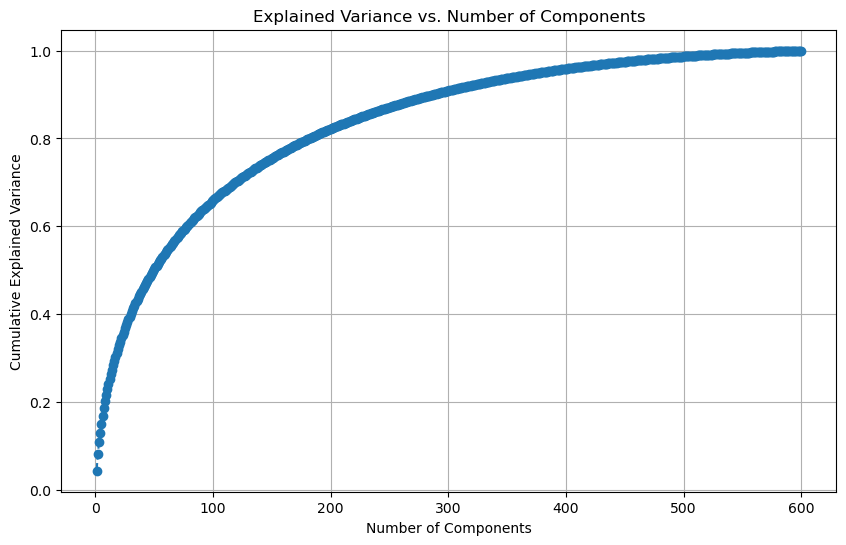

Number of components to retain 95.0% variance: 378


In [103]:
tegu_200_TESTING.pca_features(years=[2018, 2019, 2020, 2021, 2022, 2023], model=resnet, variance_min=0.95, plot_variance=True)

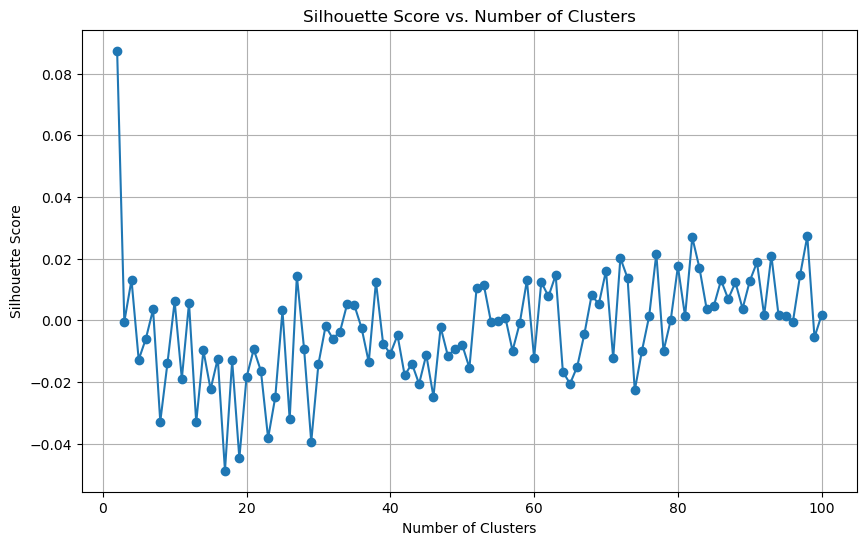

In [107]:
sil = tegu_200_TESTING.calc_silhouette_score(years=[2018, 2019, 2020, 2021, 2022, 2023], model=resnet, show_plot=True)

In [112]:
# Print the highest score found in the list sil
print(max(sil[15:]))

# Print the index of the highest score found in the list sil
print(sil.index(max(sil[15:])))

0.027260102
96


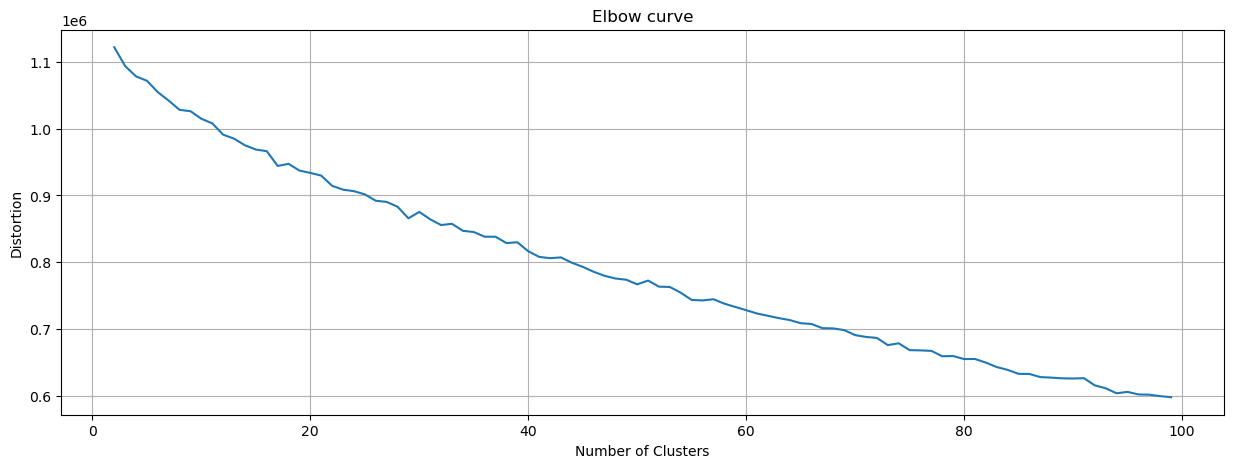

In [106]:
tegu_200_TESTING.plot_elbow_curve(years=[2018, 2019, 2020, 2021, 2022, 2023], model=resnet)

In [113]:
tegu_200_TESTING.calc_kmeans_clusters(years=[2018, 2019, 2020, 2021, 2022, 2023], model=resnet, n_clusters=96)

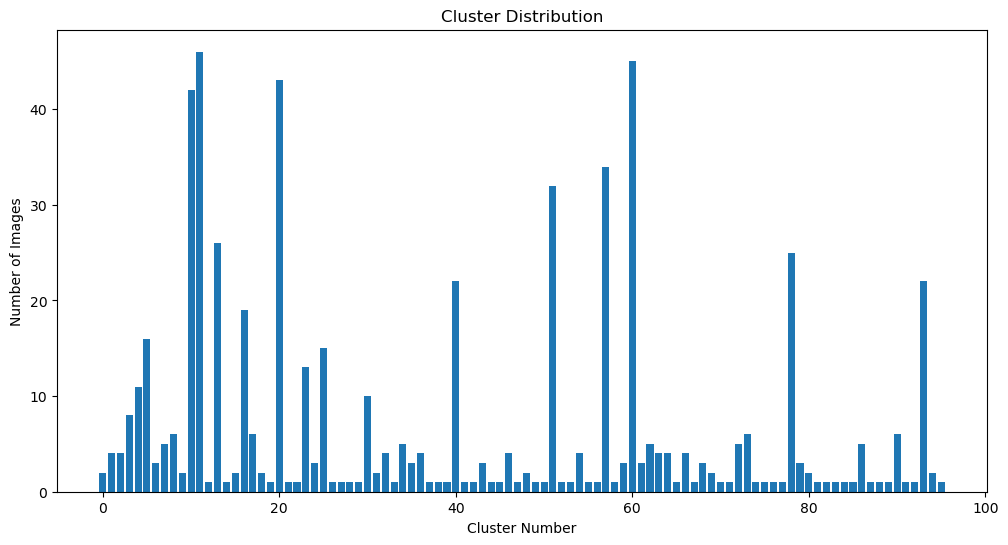

In [11]:
tegu_200_TESTING.plot_cluster_counts(years=[2018, 2019, 2020, 2021, 2022, 2023], model=resnet)

In [114]:
tegu_200_TESTING.update_database()

# Previous Steps ^

In [35]:
import eloisa
reload(eloisa)
from eloisa import Eloisa

In [36]:
tegu_200_TESTING = Eloisa(name="tegu_200x200_TESTING", db_folder="eloisa_databases", seed=SEED, image_shape=(200, 200, 3))

The database already exists. Connecting to it.


100%|██████████| 600/600 [00:25<00:00, 23.69it/s]


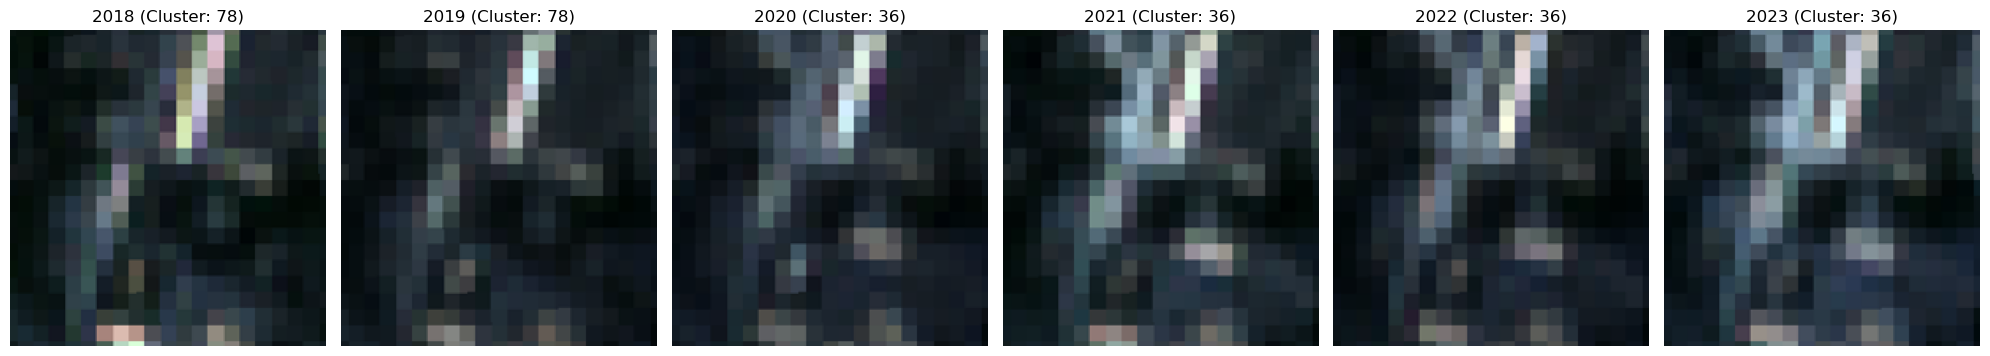

In [37]:
tegu_200_TESTING.show_clip_by_year([2018, 2019, 2020, 2021, 2022, 2023], 64, model=resnet)

In [12]:
tegucigalpa_image = AnalysisImage(presets='Tegucigalpa', year=2018, feature_bands=FEATURES)

img_height = haversine(coords=tegucigalpa_image.get_bounds(side='ceiling'))
img_width = haversine(coords=tegucigalpa_image.get_bounds(side='left'))

x_num_parts, y_num_parts = calc_segment_count(img_height, img_width, 200, 200)

subgeometries = split_geometry(tegucigalpa_image.geometry_sd, x_num_parts=x_num_parts, y_num_parts=y_num_parts)

In [85]:
import cluster_tester
reload(cluster_tester)
from cluster_tester import ClusterTester

In [38]:
# Get cluster location multipolygons
cluster_location_info = tegu_200_TESTING.get_cluster_location_info(year=2023, model=resnet, subgeometries=subgeometries, dissolve_by_cluster=True)

In [16]:
precario_path = os.path.join("data", "tegucigalpa_PC.zip")
precario_gdf = gpd.read_file(precario_path)

In [86]:
tegu_cluster_tester = ClusterTester(cluster_location_info=cluster_location_info, analysis_image=tegucigalpa_image, validation_data=precario_gdf)

In [45]:
tegu_cluster_tester.plot_clusters()

Map(center=[14.0763396, -87.20787405], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=…

In [87]:
points = tegu_cluster_tester.create_sampling_points(n_points=1000)

In [88]:
cluster_metrics = tegu_cluster_tester.calc_sampling_metrics()

In [89]:
grouped_metrics = tegu_cluster_tester.group_clusters_and_calc_metrics(precision_min=0)

100%|██████████| 1585/1585 [00:42<00:00, 36.92it/s]


In [90]:
tegu_cluster_tester.plot_top_cluster_combos(metric='F1', n_combos=5)

Map(center=[14.0763396, -87.20787405], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=…